## **Lunar Lander Training - DDQN**

### Imports and Setups

In [1]:
import os
import random
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from itertools import count

print(gym.__version__)
print(torch.__version__)

1.1.1
2.6.0


### GPU Check

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Hyperparameters

In [4]:
# Hyperparameters
MAX_EPISODES = 600
MEMORY_SIZE = 10000
ROLLING_WINDOW = 20
MAX_STEPS = 1000

gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 1e-4
batch_size = 128
solved_threshold = 200
TAU = 0.005

### Environment Setup

In [5]:
env = gym.make("LunarLander-v3")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

### Building Training Model

In [6]:
#Model Definition
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#Initialize Networks & Optimizer
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=learning_rate)
criterion = nn.SmoothL1Loss()

### Replay Buffer & Functions

In [7]:
Transition = namedtuple("Transition", ["state", "action", "next_state", "reward", "done"])

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

replay_buffer = ReplayMemory(MEMORY_SIZE)

def select_action(state):
    global epsilon
    if np.random.rand() < epsilon:
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long, device=device)
    with torch.no_grad():
        return policy_net(state).max(1).indices.view(1, 1)

### Training Loop - DDQN

In [8]:
rewards_per_episode = []
rolling_avg_rewards = []

start_time = time.time()

for episode in range(MAX_EPISODES):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0

    for t in count():
        action = select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action.item())

        done = terminated or truncated
        reward_tensor = torch.tensor([reward], device=device)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

        replay_buffer.push(state, action, next_state_tensor, reward_tensor, done)
        state = next_state_tensor
        total_reward += reward

        if len(replay_buffer) >= batch_size:
            transitions = replay_buffer.sample(batch_size)
            states, actions, next_states, rewards, dones = zip(*transitions)

            states_batch = torch.cat(states)
            next_states_batch = torch.cat(next_states)
            actions_batch = torch.cat(actions)
            rewards_batch = torch.cat(rewards)
            dones_batch = torch.tensor(dones, device=device)

            # --- DDQN logic ---
            best_actions = policy_net(next_states_batch).argmax(1, keepdim=True)
            q_values = target_net(next_states_batch).gather(1, best_actions).squeeze()

            q_target = rewards_batch + gamma * q_values * ~dones_batch
            q_policy = policy_net(states_batch).gather(1, actions_batch)

            loss = criterion(q_policy, q_target.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
            optimizer.step()

            # Soft update of target network
            for target_param, main_param in zip(target_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(TAU * main_param.data + (1.0 - TAU) * target_param.data)

        if done or t >= MAX_STEPS:
            rewards_per_episode.append(total_reward)
            rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])
            rolling_avg_rewards.append(rolling_avg)

            print(f"Episode {episode+1}/{MAX_EPISODES}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:.2f}, Steps: {t}")
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        break

end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")

Episode 1/600, Reward: -75.30, Epsilon: 1.00, Rolling Avg: -75.30, Steps: 61
Episode 2/600, Reward: -89.13, Epsilon: 0.99, Rolling Avg: -82.21, Steps: 59
Episode 3/600, Reward: -92.46, Epsilon: 0.99, Rolling Avg: -85.63, Steps: 109
Episode 4/600, Reward: -107.65, Epsilon: 0.99, Rolling Avg: -91.13, Steps: 76
Episode 5/600, Reward: -100.37, Epsilon: 0.98, Rolling Avg: -92.98, Steps: 57
Episode 6/600, Reward: -127.64, Epsilon: 0.98, Rolling Avg: -98.76, Steps: 91
Episode 7/600, Reward: -128.47, Epsilon: 0.97, Rolling Avg: -103.00, Steps: 98
Episode 8/600, Reward: -107.66, Epsilon: 0.97, Rolling Avg: -103.58, Steps: 59
Episode 9/600, Reward: -132.69, Epsilon: 0.96, Rolling Avg: -106.82, Steps: 125
Episode 10/600, Reward: -294.05, Epsilon: 0.96, Rolling Avg: -125.54, Steps: 99
Episode 11/600, Reward: -111.26, Epsilon: 0.95, Rolling Avg: -124.24, Steps: 82
Episode 12/600, Reward: -205.32, Epsilon: 0.95, Rolling Avg: -131.00, Steps: 74
Episode 13/600, Reward: -195.74, Epsilon: 0.94, Rolling 

### Plot Rewards

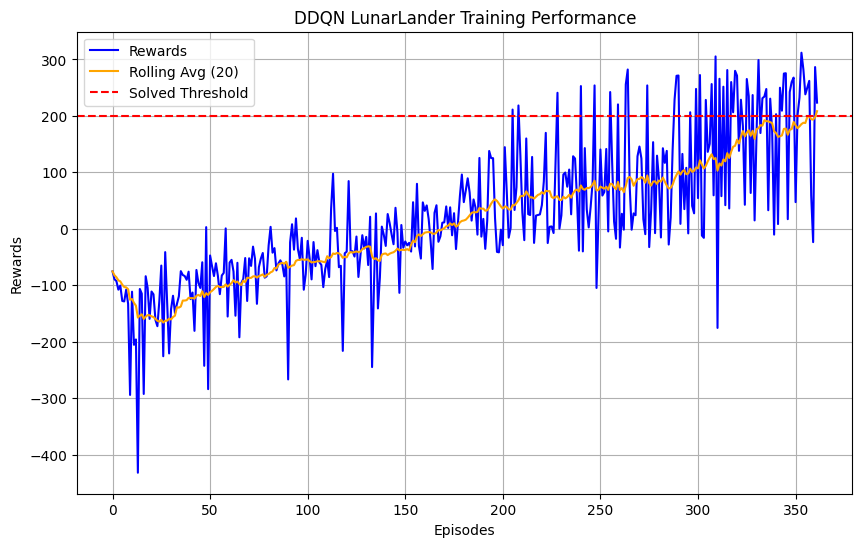

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label=f'Rolling Avg ({ROLLING_WINDOW})', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DDQN LunarLander Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

### Save Model

In [13]:
model_path = os.path.join("..", "models", "ddqn_lunarlander.pth")
torch.save(policy_net.state_dict(), model_path)
print(f"Model saved successfully at {model_path}!")

Model saved successfully at ../models/ddqn_lunarlander.pth!
